# Explore here

In [597]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB



 Reading the data set

In [598]:
df = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv")
df.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


Data Processing

In [599]:
tfidf = False
df["spam"] = df["is_spam"].astype(int)

In [600]:
df.head()

,url,is_spam,spam
0,https://briefingday.us8.list-manage.com/unsubs...,True,1
1,https://www.hvper.com/,True,1
2,https://briefingday.com/m/v4n3i4f3,True,1
3,https://briefingday.com/n/20200618/m#commentform,False,0
4,https://briefingday.com/fan,True,1


In [601]:
df.shape

(2999, 3)

In [602]:
df_new = df.drop_duplicates()
df_new = df_new.reset_index(inplace = False, drop = True)
df_new.shape

(2369, 3)

In [603]:
print(f"Spam: {len(df_new.loc[df_new['is_spam'] == 1])}")
print(f"No spam: {len(df_new.loc[df_new['is_spam'] == 0])}")

Spam: 244
No spam: 2125


In [604]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2369 entries, 0 to 2368
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      2369 non-null   object
 1   is_spam  2369 non-null   bool  
 2   spam     2369 non-null   int64 
dtypes: bool(1), int64(1), object(1)
memory usage: 39.5+ KB


In [605]:
print(type(df_new))

<class 'pandas.core.frame.DataFrame'>


Textprocessing

In [606]:
def extract_domain_regex(url):
    pattern = r'://(?:www\.)?([\w\-\.]+)'
    find = re.findall(pattern, url)
    if find:
        return find[0]
    else:
        return None

df_new['regex'] = df_new['url'].apply(extract_domain_regex)
print(df_new[['url', 'regex']].head())


                                                 url  \
0  https://briefingday.us8.list-manage.com/unsubs...   
1                             https://www.hvper.com/   
2                 https://briefingday.com/m/v4n3i4f3   
3   https://briefingday.com/n/20200618/m#commentform   
4                        https://briefingday.com/fan   

                             regex  
0  briefingday.us8.list-manage.com  
1                        hvper.com  
2                  briefingday.com  
3                  briefingday.com  
4                  briefingday.com  


In [607]:
def preprocess_text(text):
    text = re.sub(r'[^a-z ]', " ", text)

    text = re.sub(r'\s+[a-zA-Z]\s+', " ", text)
    text = re.sub(r'\^[a-zA-Z]\s+', " ", text)

    text = re.sub(r'\s+', " ", text.lower())

    text = text.replace('http','').replace('https','')

    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)
    return text.split()
df_new["regex"] = df_new["url"].apply(preprocess_text)
df_new.head()

,url,is_spam,spam,regex
0,https://briefingday.us8.list-manage.com/unsubs...,True,1,"[s, briefingday, us, list, manage, com, unsubs..."
1,https://www.hvper.com/,True,1,"[s, www, hvper, com]"
2,https://briefingday.com/m/v4n3i4f3,True,1,"[s, briefingday, com, v, i]"
3,https://briefingday.com/n/20200618/m#commentform,False,0,"[s, briefingday, com, m, commentform]"
4,https://briefingday.com/fan,True,1,"[s, briefingday, com, fan]"


In [608]:
df_new["url"] = df_new["url"].apply(preprocess_text)
df_new.head()

,url,is_spam,spam,regex
0,"[s, briefingday, us, list, manage, com, unsubs...",True,1,"[s, briefingday, us, list, manage, com, unsubs..."
1,"[s, www, hvper, com]",True,1,"[s, www, hvper, com]"
2,"[s, briefingday, com, v, i]",True,1,"[s, briefingday, com, v, i]"
3,"[s, briefingday, com, m, commentform]",False,0,"[s, briefingday, com, m, commentform]"
4,"[s, briefingday, com, fan]",True,1,"[s, briefingday, com, fan]"


Tokenization

In [609]:
download("wordnet")
lemmatizer = WordNetLemmatizer()

download("stopwords")
stop_words = stopwords.words("english")

def lemmatize_text(words, lemmatizer = lemmatizer):
    tokens = [lemmatizer.lemmatize(word) for word in words]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if len(word) > 3]
    return tokens

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nandapop/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nandapop/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


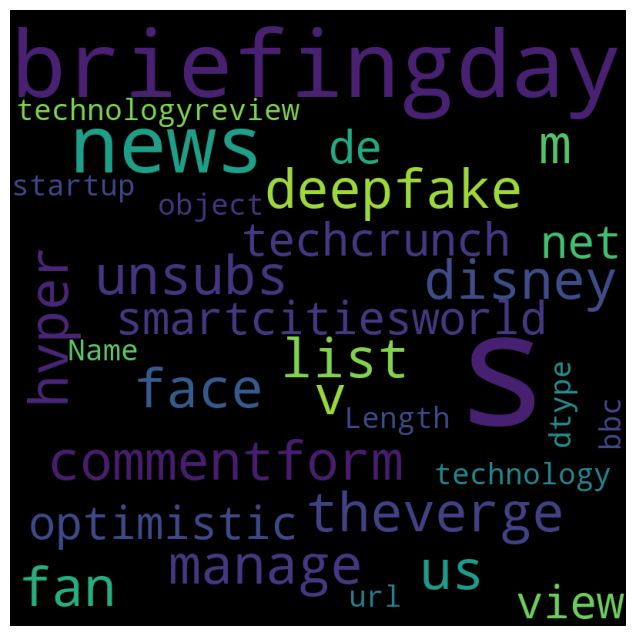

In [610]:
wordcloud = WordCloud(width = 800, height = 800, background_color = "black", max_words = 1000, min_font_size = 20, random_state = 42)\
    .generate(str(df_new["url"]))

fig = plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig(".../Documents/Bootcamp/NLP_Project/src/wordcloud.png")
plt.show()


Vectorize the data

In [611]:
tokens_list = df_new["url"]
tokens_list = [" ".join(tokens) for tokens in tokens_list]

if tfidf:
    vectorizer = TfidfVectorizer(max_features = 5000, max_df = 0.8, min_df = 5)
else:
    vectorizer = CountVectorizer(max_features = 5000, max_df = 0.8, min_df = 5)

X = vectorizer.fit_transform(tokens_list).toarray()
y = df_new["is_spam"]

X[:5]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Split the data and train the model

In [612]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify=y)

SVC model

In [613]:
model = SVC(kernel="linear", class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

SVC(class_weight='balanced', kernel='linear', random_state=42)

In [614]:
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

In [615]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.98      0.85      0.91       425
        True       0.40      0.86      0.54        49

    accuracy                           0.85       474
   macro avg       0.69      0.85      0.73       474
weighted avg       0.92      0.85      0.87       474



In [616]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       False       0.98      0.85      0.91       425
        True       0.40      0.86      0.54        49

    accuracy                           0.85       474
   macro avg       0.69      0.85      0.73       474
weighted avg       0.92      0.85      0.87       474



In [617]:
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Testing Accuracy: {test_accuracy:.2f}")

Training Accuracy: 0.88
Testing Accuracy: 0.85


In [618]:
gap = train_accuracy - test_accuracy
print(f"Accuracy Gap (Training - Testing): {gap:.2f}")

Accuracy Gap (Training - Testing): 0.03


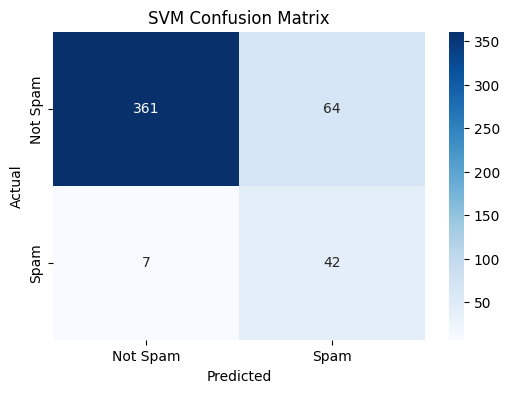

In [619]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SVM Confusion Matrix')
plt.savefig(".../Documents/Bootcamp/NLP_Project/src/confusion_matrix_default.png")
plt.show()

Model Optimization

In [620]:
hyperparams = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf']
}

In [621]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
svm = SVC(class_weight='balanced', random_state=42)

In [622]:
grid = GridSearchCV(
    estimator=svm,
    param_grid=hyperparams,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

In [623]:
grid.fit(X_train, y_train)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVC(class_weight='balanced', random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             scoring='f1', verbose=1)

In [624]:
print("Best Hyperparameters:", grid.best_params_)
best_model = grid.best_estimator_

Best Hyperparameters: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}


In [625]:
y_pred_optimized = best_model.predict(X_test)
print(classification_report(y_test, y_pred_optimized))

              precision    recall  f1-score   support

       False       0.96      0.90      0.93       425
        True       0.42      0.63      0.51        49

    accuracy                           0.87       474
   macro avg       0.69      0.77      0.72       474
weighted avg       0.90      0.87      0.88       474



In [626]:
optimized_train_accuracy = best_model.score(X_train, y_train)
optimized_test_accuracy = best_model.score(X_test, y_pred_optimized)
print(f"Optimized Training Accuracy: {optimized_train_accuracy:.2f}")
print(f"Optimized Testing Accuracy: {optimized_test_accuracy:.2f}")

Optimized Training Accuracy: 0.88
Optimized Testing Accuracy: 1.00


Optimized Testing F1-Score: 0.51


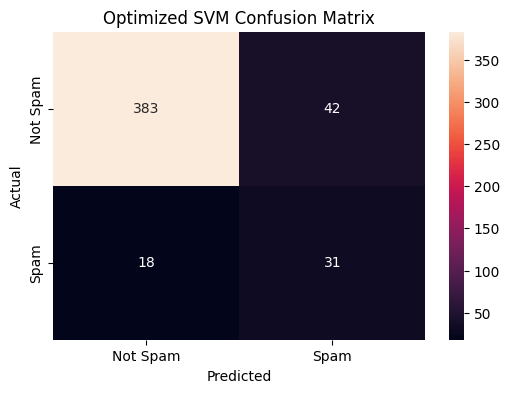

In [627]:
optimized_f1 = f1_score(y_test, y_pred_optimized)

print(f"Optimized Testing F1-Score: {optimized_f1:.2f}")

# Confusion Matrix for Optimized Model
cm_optimized = confusion_matrix(y_test, y_pred_optimized)
plt.figure(figsize=(6,4))
sns.heatmap(cm_optimized, annot=True, fmt="d", xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Optimized SVM Confusion Matrix')
plt.savefig('../Documents/Bootcamp/NLP_Project/src/confusion_matrix_opt.png')
plt.show()

Logistic Regression

In [628]:
model_regression = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)

model_regression.fit(X_train, y_train)

y_train_pred_log = model_regression.predict(X_train)
y_pred_log = model_regression.predict(X_test)

In [629]:
print(classification_report(y_train, y_train_pred_log))

print(classification_report(y_test, y_pred_log))

train_accuracy_log = accuracy_score(y_train, y_train_pred_log)
test_accuracy_log = accuracy_score(y_test, y_pred_log)
print(f"Logistic Regression Training Accuracy: {train_accuracy_log:.2f}")
print(f"Logistic Regression Testing Accuracy: {test_accuracy_log:.2f}")

test_f1_log = f1_score(y_test, y_pred_log)
print(f"Logistic Regression Testing F1-Score: {test_f1_log:.2f}")

              precision    recall  f1-score   support

       False       1.00      0.87      0.93      1700
        True       0.47      0.97      0.63       195

    accuracy                           0.88      1895
   macro avg       0.73      0.92      0.78      1895
weighted avg       0.94      0.88      0.90      1895

              precision    recall  f1-score   support

       False       0.97      0.86      0.91       425
        True       0.39      0.80      0.53        49

    accuracy                           0.85       474
   macro avg       0.68      0.83      0.72       474
weighted avg       0.91      0.85      0.87       474

Logistic Regression Training Accuracy: 0.88
Logistic Regression Testing Accuracy: 0.85
Logistic Regression Testing F1-Score: 0.53


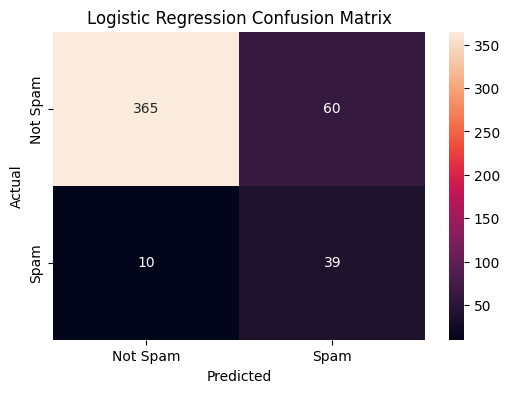

In [630]:
cm= confusion_matrix(y_test, y_pred_log)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", 
            xticklabels=['Not Spam', 'Spam'], 
            yticklabels=['Not Spam', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix')
plt.savefig("../Documents/Bootcamp/NLP_Project/src/confusion_matrix_lr.png")
plt.show()

Random Forest

In [631]:
rf = RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100)

In [632]:
rf.fit(X_train, y_train)
y_train_pred_rf = rf.predict(X_train)
y_pred_rf = rf.predict(X_test)
print(classification_report(y_train, y_train_pred_rf))
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

       False       1.00      0.92      0.96      1700
        True       0.59      0.97      0.73       195

    accuracy                           0.93      1895
   macro avg       0.79      0.95      0.84      1895
weighted avg       0.95      0.93      0.93      1895

              precision    recall  f1-score   support

       False       0.97      0.90      0.93       425
        True       0.46      0.78      0.58        49

    accuracy                           0.88       474
   macro avg       0.72      0.84      0.76       474
weighted avg       0.92      0.88      0.90       474



Random Forest Training Accuracy: 0.93
Random Forest Testing Accuracy: 0.88
Random Forest Testing F1-Score: 0.58


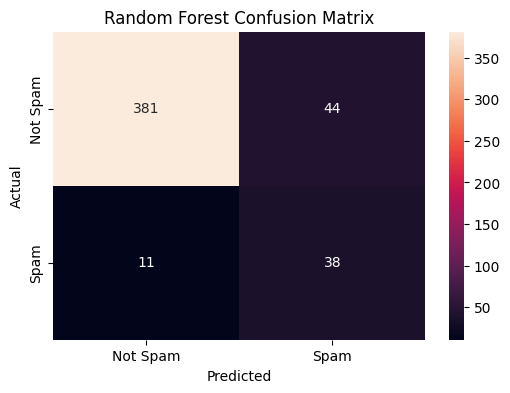

In [633]:
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
test_accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Training Accuracy: {train_accuracy_rf:.2f}")
print(f"Random Forest Testing Accuracy: {test_accuracy_rf:.2f}")

test_f1_rf = f1_score(y_test, y_pred_rf)
print(f"Random Forest Testing F1-Score: {test_f1_rf:.2f}")

cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt="d", 
            xticklabels=['Not Spam', 'Spam'], 
            yticklabels=['Not Spam', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.savefig("../Documents/Bootcamp/NLP_Project/src/confusion_matrix_rf.png")
plt.show()

Naive Bayes

In [634]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_train_pred_nb = nb.predict(X_train)
y_pred_nb = nb.predict(X_test)

In [635]:
print(classification_report(y_train, y_train_pred_nb))
print(classification_report(y_test, y_pred_nb))
train_accuracy_nb = accuracy_score(y_train, y_train_pred_nb)
test_accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Naive Bayes Training Accuracy: {train_accuracy_nb:.2f}")
print(f"Naive Bayes Testing Accuracy: {test_accuracy_nb:.2f}")

              precision    recall  f1-score   support

       False       0.95      0.98      0.97      1700
        True       0.80      0.54      0.64       195

    accuracy                           0.94      1895
   macro avg       0.88      0.76      0.81      1895
weighted avg       0.93      0.94      0.93      1895

              precision    recall  f1-score   support

       False       0.95      0.96      0.96       425
        True       0.63      0.53      0.58        49

    accuracy                           0.92       474
   macro avg       0.79      0.75      0.77       474
weighted avg       0.91      0.92      0.92       474

Naive Bayes Training Accuracy: 0.94
Naive Bayes Testing Accuracy: 0.92


Naive Bayes Testing F1-Score: 0.58


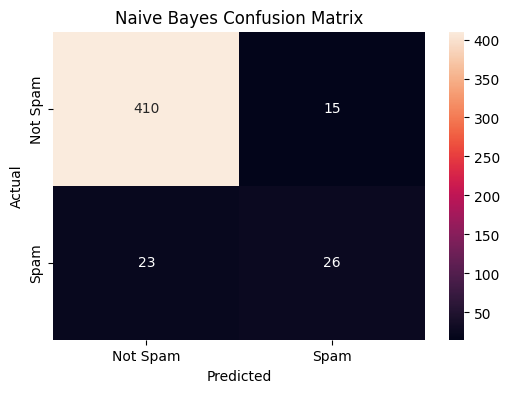

In [636]:
test_f1_nb = f1_score(y_test, y_pred_nb)
print(f"Naive Bayes Testing F1-Score: {test_f1_nb:.2f}")
cm_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(6,4))
sns.heatmap(cm_nb, annot=True, fmt="d", 
            xticklabels=['Not Spam', 'Spam'], 
            yticklabels=['Not Spam', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Naive Bayes Confusion Matrix')
plt.savefig('.../Documents/Bootcamp/NLP_Project/src/confusion_matrix_nb.png')
plt.show()